In [1]:
#referencing paper "Attention is all you need"

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor


In [2]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time 

sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

# Transformer Parameters
# Padding Should be Zero

src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4}
src_vocab_size = len(src_vocab)       #src_vocab_size=v_x=5

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'S' : 5, 'E' : 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)       #tgt_vocab_size=v_y=7

src_len = 5      #m_x
tgt_len = 5      #m_y

d_model = 512  # Embedding Size=d
d_ff = 2048    # dimension  of feedforward      等于Conv1d操作中的output_channel，等于Conv1d操作中的number_of_filter
d_k = d_v = 64  # dimension of K(=Q), V    =d_model/n_head=512/8=64
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention


def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return Variable(torch.LongTensor(input_batch)), Variable(torch.LongTensor(output_batch)), Variable(torch.LongTensor(target_batch))

enc_inputs, dec_inputs, target_batch = make_batch(sentences)
# enc_inputs: 'ich mochte ein bier P'======>[1,2,3,4,0]
# dec_inputs:  'S i want a beer'===========>[5,1,2,3,4]
# target_batch:'i want a beer E'===========>[1,2,3,4,6]
print(enc_inputs.size(),dec_inputs.size(),target_batch.size())



torch.Size([1, 5]) torch.Size([1, 5]) torch.Size([1, 5])


In [3]:
#get_sinusoid_encoding_table()  返回(m_x+1,d)的矩阵
def get_sinusoid_encoding_table(n_position, d_model):      #(m_x+1,d)           得到正弦曲线 编码  表              positional encoding
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    # print(sinusoid_table.shape)    #(m_x,d) = (6,512)
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])    # 当hid_idx为偶数时： =sin（x）
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])    # 当hid_idx为奇数时：  =cos（x）
    return torch.FloatTensor(sinusoid_table)

    # sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in r


def get_attn_pad_mask(seq_q, seq_k):         #(b,m_x) ,(b,m_x)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)       #(b,m_x)===>(b,1,m_x)    one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # (b,m_q,m_k)=(b,m_x,m_x)     batch_size x len_q x len_k


def get_attn_subsequent_mask(seq):                 # (b,m_y) 
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]   #(b,m_y,m_y)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask       #(b,m_y,m_y)

In [4]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):       #forward(  (b,8,m_q,d_k), (b,8,m_,d_k), (b,8,m_,d_k), (b,8,m_q,m_k)   ) 
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : (b,8,m_q,m_q)
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)     #(b,8,m_q,m_q)
        context = torch.matmul(attn, V)       #(b,8,m_q,m_k)*(b,8,m_v,d_v)=(b,8,m_q,d_v)
        return context, attn         #(b,8,m_q,d_v)   (b,8,m_q,m_q)          
    
    
    

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads) #(d,8*d_k)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):          #forward(  (b,m_q,d),(b,m_k,d),(b,m_k,d),   (b,m_q,m_k) )       
        residual, batch_size = Q, Q.size(0)      #residual:(b,m_q,d)  是进行multi_head_attettion操作之前copy的数据，等于enc_outputs
        #(8d_q,d) * (b,m_q,d)=(8*d_q,b,m_q)====>(b,m_q,8,d_k)=====>(b,8,m_q,d_q)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: (b,8,m_q,d_q)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s:(b,8,m_k,d_k)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: (b,8,m_k,d_k)
       
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)                # attn_mask :  (b,m_q,m_k) ===>(b,1,m_q,m_k)==>(b,8,m_q,m_k)
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)      # context:(b,8,m_q,d_v)         attn: (b,8,m_x,m_x) 
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)  #context:(b,8,m_q,d_v) ==>(b,m_q,8,d_v)====>(b,m_q,8*d_v)
        output = nn.Linear(n_heads * d_v, d_model)(context)                        #ouput:(8*d_v,d)*(b,m_q,8*d_k)=(b,m_q,d)
        return nn.LayerNorm(d_model)(output + residual), attn                      #  return:(b,m_q,d), (b,8,m_x,m_x) 



class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)

    def forward(self, inputs):       # (b,m_x,d)         #(b,d，m_x) 运行conv1操作（把d当做input_channel）,得到(b,output_channle,m_x)
        residual = inputs    #residual: (b,m_x,d) 
        inputs=inputs.transpose(1,2)  # (b,m_x,d)========>#(b,input_channel(=d),m_x)  
        inputs=self.conv1(inputs)    #(b,input_channel(=d),m_x)----->在input_channel方向做卷积操作------>(b,output_channle(=d_ff),m_x)=(1,2028，5)
        output = nn.ReLU()(inputs)  
        
        #(b,input_channel(=d_ff),m_x)-->在input_channel方向做卷积操作-->(b,output_channle(=d_model),m_x)--->(b,m_x,d)=(1,5,512)
        output = self.conv2(output).transpose(1, 2) 
        
        return nn.LayerNorm(d_model)(output + residual)  #return (b,m_x,d)


class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()             #position_feed_forward_network

    def forward(self, enc_inputs, enc_self_attn_mask):       #forward(  (b,m_x,d),(b,m_q,m_k) )
                          # self.enc_self_attn(  (b,m_x,d),(b,m_x,d),(b,m_x,d),   (b,m_q,m_k) )         
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_outputs:(b,m_x,d)  attn:(b,8,m_x,m_x)
        enc_outputs = self.pos_ffn(enc_outputs) # self.pos_ffn( (b,m_x,d) )======>(b,m_x,d)
        return enc_outputs, attn         #(b,m_x,d)   (b,8,m_x,m_x)




class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()         # position_feed_forward_network

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask): #forward(  (b,m_y,d),(b,m_x,d), (b,m_y,m_y),(b,m_x,m_y)    )
                                   # self.enc_self_attn(  (b,m_y,d),(b,m_y,d),(b,m_y,d),   (b,m_y,m_y) ) 
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)#dec_outputs:(b,m_y,d) attn:(b,8,m_y,m_y) 
        #dec_outputs作为q，enc_outpus作为k和v    #self.enc_self_attn(  (b,m_y,d),(b,m_x,d),(b,m_x,d),   (b,m_y,m_y) ) = self.dec_enc_atten( Q, K, V,attn_mask) 
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)#dec_outputs:(b,m_y,d) attn:(b,8,m_y,m_y) 
        dec_outputs = self.pos_ffn(dec_outputs)     # self.pos_ffn( (b,m_y,d) )======>(b,m_y,d)                            
        return dec_outputs, dec_self_attn, dec_enc_attn        # (b,m_y,d)   (b,8,m_y,m_y)     (b,8,m_x,m_y)
 


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)   #(v_x,d)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)  #(m_x+1,d)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs:(b,m_x)  
        # print(self.src_emb(enc_inputs).size())                                #(v_x,d)  *  (b,m_x) = (b,m_x,d)
        # print(self.pos_emb(torch.LongTensor([[1,2,3,4,0]])).size())           #(m_x,d)* (b,m_x) = (b,m_x,d)
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))      #(b,m_x,d) + (b,m_x,d) =(b,m_x,d) 
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)            #get_attn_pad_mask(  (b,m_x) ,(b,m_x)  )  ======>(b,m_q,m_k)
        enc_self_attns = []
        for layer in self.layers:     #n_layers(=6)个一样的encoder layer       每一次做一次迭代
            # enc_outputs:(b,m_x,d)        enc_self_attn:(b,8,m_x,m_x)
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)         #layer(  (b,m_x,d),(b,m_q,m_k) )
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns      # enc_outputs:(b,m_x,d)        enc_self_attns是数组，每个元素：(b,8,m_x,m_x)
 




class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)   #(v_y,d)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):          #forward( (b,m_y),(b,m_x),(b,m_x,d) )                      
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))        #(b,m_y,d) + (b,m_y,d) = (b,m_y,d) 
        
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)    #get_attn_pad_mask(  (b,m_y) ,(b,m_y)  )  ======>(b,m_q,m_k)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)   #get_attn_subsequent_mask( (b,m_y) )======>(b,m_y,m_y)
        dec_self_attn_mask = torch.gt( (dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0  )  #(b,m_y,m_y)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)           ##(b,m_x,m_y)  

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:               #n_layers(=6)个一样的decoder layer       每一次做一次迭代
                                                      #layer(  (b,m_y,d),(b,m_x,d), (b,m_y,m_y),(b,m_x,m_y)    )
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            # enc_outputs:(b,m_y,d)        dec_self_attn: (b,8,m_y,m_y)      dec_enc_attn:(b,8,m_x,m_y)
                                                      
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns    # dec_outputs:(b,m_y,d)     dec_self_attns和dec_enc_attns是数组，每个元素：(b,8,m_y,m_y)



class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)    #(d,v_y)
    def forward(self, enc_inputs, dec_inputs):              #forward (  (b,m_x ),(b,m_y)  )   
         # enc_outputs:(b,m_x,d)        enc_self_attns是数组，每个元素：(b,8,m_x,m_x)
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)        #(b,m_x)
         
         #dec_outputs:(b,m_y,d)     dec_self_attns和dec_enc_attns是数组，每个元素：(b,8,m_y,m_y)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)   #self.decoder( (b,m_y),(b,m_x),(b,m_x,d) )
         
        dec_logits = self.projection(dec_outputs)     #(d,v_y)* (b,m_y,d) = (b,m_y,v_y) 
        dec_logits = dec_logits.view(-1, dec_logits.size(-1)) #(b,m_y,v_y)------->(b*m_y,v_y)
         
        #dec_logits：(b*m_y,v_y)      enc_self_attn和sec_self_attns和dec_enc_attns是数组，每个元素：(b,8,m,m)
        return  dec_logits,enc_self_attns, dec_self_attns, dec_enc_attns    
      


def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()


In [5]:
model = Transformer()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(    filter(lambda p: p.requires_grad,model.parameters()),   lr=0.001)
'''
Transformer(

  (encoder): Encoder(
    (src_emb): Embedding(5, 512)
    (pos_emb): Embedding(6, 512)
    (layers): ModuleList(
    
      (0-5): EncoderLayer(            #6个一样的encoder layer
        (enc_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
          (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        )
      )

    )
  )
  
  (decoder): Decoder(                 #6个一样的decoder layer
    (tgt_emb): Embedding(7, 512)
    (pos_emb): Embedding(6, 512)
    (layers): ModuleList(
    
      (0-5): DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
        )
        (dec_enc_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
          (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        )
      )
      
    )
  )
  
  
  (projection): Linear(in_features=512, out_features=7, bias=False)
)

'''



'\nTransformer(\n\n  (encoder): Encoder(\n    (src_emb): Embedding(5, 512)\n    (pos_emb): Embedding(6, 512)\n    (layers): ModuleList(\n    \n      (0-5): EncoderLayer(            #6个一样的encoder layer\n        (enc_self_attn): MultiHeadAttention(\n          (W_Q): Linear(in_features=512, out_features=512, bias=True)\n          (W_K): Linear(in_features=512, out_features=512, bias=True)\n          (W_V): Linear(in_features=512, out_features=512, bias=True)\n        )\n        (pos_ffn): PoswiseFeedForwardNet(\n          (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))\n          (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))\n        )\n      )\n\n    )\n  )\n  \n  (decoder): Decoder(                 #6个一样的decoder layer\n    (tgt_emb): Embedding(7, 512)\n    (pos_emb): Embedding(6, 512)\n    (layers): ModuleList(\n    \n      (0-5): DecoderLayer(\n        (dec_self_attn): MultiHeadAttention(\n          (W_Q): Linear(in_features=512, out_features=512, bias=True)\n    

In [6]:
for epoch in range(1):
    optimizer.zero_grad()
    enc_inputs, dec_inputs, target_batch = make_batch(sentences)        
    print(enc_inputs,dec_inputs,target_batch)
    print(enc_inputs.size(),dec_inputs.size(),target_batch.size())
    
    #output：(b*m_y,v_y)      enc_self_attn和sec_self_attns和dec_enc_attns是数组，每个元素：(b,8,m,m)
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)   #model( (b,m_x ),(b,m_y)  )
    target=target_batch.contiguous().view(-1)      #  (b*m_y)
    loss = criterion(outputs,target)   #criterion(  (b*m_y,v_y), (b*m_y)  )
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()


tensor([[ 1,  2,  3,  4,  0]]) tensor([[ 5,  1,  2,  3,  4]]) tensor([[ 1,  2,  3,  4,  6]])
torch.Size([1, 5]) torch.Size([1, 5]) torch.Size([1, 5])
Epoch: 0001 cost = 1.859222


ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']
first head of last state enc_self_attns


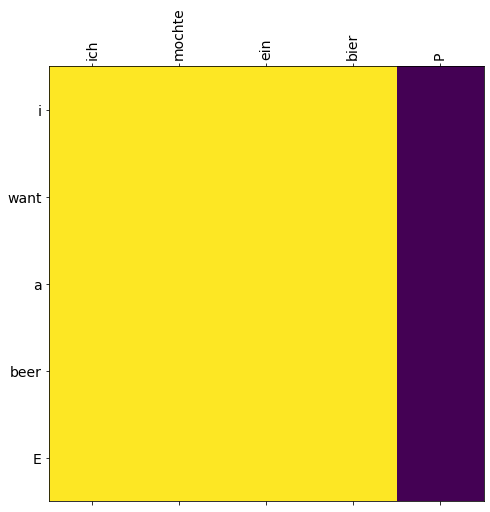

first head of last state dec_self_attns


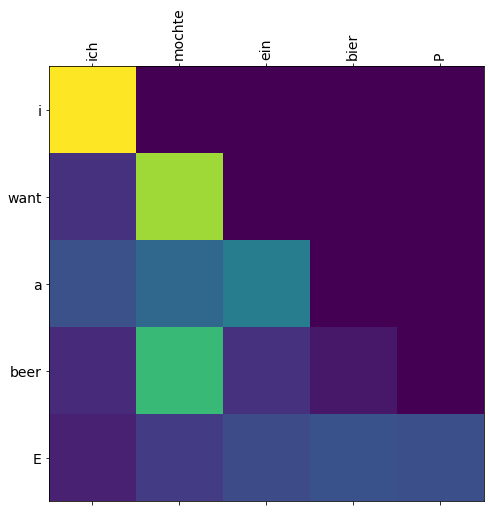

first head of last state dec_enc_attns


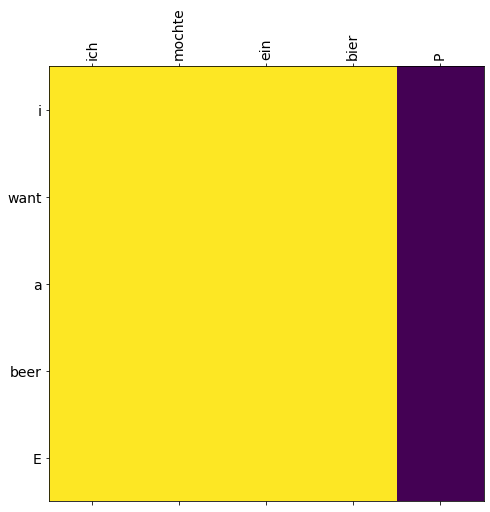

In [9]:
# Test
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

print('first head of last state enc_self_attns')
showgraph(enc_self_attns)

print('first head of last state dec_self_attns')
showgraph(dec_self_attns)

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)